## Dynamic model of the happiness-generation process

---

### Sep 2024 version
For a better treatment using dynamic programming, see time-dep_problem_analysis.ipynb. This file is redundant, but left here just for reference

----

## The problem

We aim to provide some mathematical reasoning as to why self-reported happiness is U-shaped over the lifespan. To try to do this, we assume happiness is a function of a stock of 'capabilities' (health, wisdom, social networks, wealth, etc), which itself evolves as a function of previous capabilities and investment, and set the problem up as choosing the investment schedule over the lifespan that optimises a certain function of happiness in the periods.
- this setup is loosely based on Graham and Oswald (2010)

The equations that formalise this are as follows:
-  Law of motion of capabilities: $h_t = z \cdot c_t^a - k \cdot i_t$ 
- Relationship between capabilities and happiness: $c_{t+1} = (1 - \delta) \cdot c_t + i_t$ 

In particular, in the first equation, the investment cost is later square rooted, to reflect the diminishing marginal returns to investment into capabilities in a given period. We investigate the features of the solution without this first, and then with it.

We (gradually) introduce into the model the following realistic features of aging:
- investment into capabilities becomes more costly in old age/investment is less effective over time (due to e.g. declining health, increased difficulty in finding jobs/income, increased difficulty travelling etc which make it harder to engage in the interactions that build up capabilities)
    - in the first equation, $k$ increases over time
    - this is later adjusted to reflect the fact that investment into capabilities really becomes more costly when capabilities are lower, rather than when the individual is older. However, there is no real change in the conclusions
- capabilities depreciate faster in old age (e.g. health declines more quickly, progression of society that you can't keep up with, etc)
    - in the second equation, $\delta$ increases over time

----

## The intuition

My intuition of the problem given these constraints is that they should lead people to want to avoid going into old age with a low capability stock because this will be very costly in terms of happiness (as it is harder to improve upon capabilities in old age). They therefore need it to be high, and the most efficient way to do that is to invest in midlife, then gradually taper off into old age.
- this fits with what seems to be the case in reality: people spend a lot of their young to mid adult life finding a partner, raising a family, working hard and climbing the corporate ladder etc, until they eventually retire, the children grow up etc and they are able to reap the rewards for these 'investments'.

It is important to realise the investment schedule we are trying to generate in order to get this happiness U-shape: starts low, then increases, then plateaus/decreases. It is worth thinking about the problem in these terms too.

Also note that initial capabilities should probably initially be high, because your family are giving them to you - this may mean we should be prioritising larger values of $c_0$.

Question: what is stopping individuals in this model from just accepting that old age will be a period of unhappiness because it is costly to maintain happiness at this stage? This is the key alternative option, which seems to be preferred by most of the model setups

----

## Document structure

This document starts by setting up the basic optimisation problem, incorporating only the second feature of ageing (capabilities depreciating faster in old age) and runs it to examine the solution. It then looks at the effect of changing parameters that don't affect the fundamental mechanics behind the model: first $z$, then $k$. It then looks at the effects of changing the objective function to a version that more precisely gives the desired evolutionary features, followed by changing it to a version that prioritises later-life happiness. Within this second version, it also looks at the effects of changing the rate at which depreciation increases with age. The model is then adjusted to account for diminishing returns to investment, and the solution is examined. It is then adjusted further to incorporate the first feature of ageing, namely that investment becomes more costly in old age. With this new model, the objective function is then changed to the precise one, and then to one in between the two. Finally, having returned to the original objective function, it investigates the effects of changing the first feature of ageing to represent the fact that the increased costliness of investment in old age should more accurately be framed as the increased costliness of investment as the capability stock falls: i.e. investment is more effective the more capabilities the individual owns at that point. After that, still using this new model, an investment schedule is simply assumed and the response in capabilities and happiness are examined, to check the mechanics of the model are as they should intuitively be. Finally, some reflective points and areas for future focus are listed.

----

## Import packages

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import brute

----

## Model setup

Fornally, we define a simplified (3 period) version of the problem as follows:

max $\Sigma_{i=0}^3 h_i^\frac{1}{2}$ w.r.t  $i_0, i_1, i_2$  under the following constraints:
- $c_{t+1} = (1 - \delta_t) \cdot c_t + i_t$, for $t = 0, 1, 2$
- $h_t = z \cdot c_t ^ \alpha - k_t \cdot i_t$, for $t = 0, 1, 2, 3$
- $c_0$ given

Important question: why this objective function? The reason is that it captures some intuitive components of an individual's happiness preferences: happiness is weighted equally in all periods, but since the derivative of $x \rightarrow x^\frac{1}{2}$ is decreasing, individuals prefer to spread their happiness over multiple periods than concentrate it all in a few (vaguely speaking). Thinking of Nature as setting the objective function to maximise gene propagation, this desire is sensible - it is important that the individual survives as long as possible, and therefore maintains a sufficiently high level of happiness throughout their life. The extreme case of this is maximising min{$h_i$}, which we look at later, but there are issues with this as will be explained.

Expanding on the point above, we can sort of see $\Sigma_{i=0}^3 h^\frac{1}{k}$ as approaching, in some sense, $min(h_i)$ as $k$ increases - happiness becomes 'more important' when there is less of it, which in the extreme case is 'happiness is crucially important when it is at its lowest', which is what the minimum is. We can use the above objective function with $k=2$ and think of it as really humans trying to maximise the minimum level of happiness over the lifespan, but subject to some imprecision in calculation. We can also try it for larger $k$ and see what happens (which we do later)

Now we move to setting up the structure required to solve it in Python

First set the basic parameters of the model

In [183]:
z = 1.0 
# c_0 needs calibration - the plots will be done for many such values
a = 0.5 # from the literature - less than 1, so that it gives diminishing returns to capabilities
d_0 = 0.4
d_1 = 0.6
d_2 = 0.8

Now define the two key equations which will be used in the next few functions: the law of motion of capabilities, and the relation between capabilities and happiness

In [184]:
def LoM(c, d, i):
    return (1 - d) * c + i

# this gives the law of motion of capabilities: c_{t+1} = (1 - d_t) * c_t + i_t

In [185]:
def happ(z, c, a, i=0):
    return z * (c ** a) - i

# this gives the relationship between capabilities and happiness: h_t = z * (c_t ** a) - i_t
# in particular, we have set k_t = 1

Define the function to be maximised, which takes in the investment schedule ${i_0, i_1, i_2}$ and returns the value of the objective function. Importantly, if the investment schedule is such that any of the investment in any period, the capability stock in any period, or the happiness in any period are negative, then the function returns `np.inf` (i.e. +$\infty$), meaning that when it comes to our maximisation - which has to be done via minimising the negative using SciPy - these investment schedules are effectively ruled out. Also note that this function gives the negative of the objective function we are really interested in: this is again because we have to minimise in SciPy, rather than maximise, so we just minimise the negative.

In [186]:
def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, i_1)
    # h_2 = z * c_2 ** a - i_2
    h_2 = happ(z, c_2, a, i_2)
    # h_3 = z * c_3 ** a
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -(h_0**0.5 + h_1**0.5 + h_2**0.5 + h_3**0.5)

Define a plotting function, that will for a given value of $c_0$ plot the evolution of investment, capabilities and happiness

In [187]:
def plot(i, t_i, c, t_c, h, t_h):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.5, 2.5))

    ax1.plot(t_i, i, marker='o', linestyle='-', color='g')
    ax1.set_title('Investment', fontsize = "7")
    ax1.set_xlabel('Time Period', fontsize = "7")

    ax2.plot(t_c, c, marker='o', linestyle='-', color='r')
    ax2.set_title('Capabilities', fontsize = "7")
    ax2.set_xlabel('Time Period', fontsize = "7")

    ax3.plot(t_h, h, marker='o', linestyle='-', color='b')
    ax3.set_title('Happiness', fontsize = "7")
    ax3.set_xlabel('Time Period', fontsize = "7")

    ax1.tick_params(axis='both', which='major', labelsize=7)
    ax2.tick_params(axis='both', which='major', labelsize=7)
    ax3.tick_params(axis='both', which='major', labelsize=7)

    fig.tight_layout()

    # Display the plots
    plt.show()

Now define a function that runs the maximisation and plots the outcome, for different values of $c_0$ (which we will define when we call this function). In partcular, it uses the 'brute' method from the scipy.optimise package - rather than relying on any iterative algorithm, this just calculates the objective function at an evenly spaced range of input values (i.e. a mesh over the domain), and takes the minimum one. Due to the setup of the objective function, there are realistic bounds for each investment value above and below, and so this is actually computationally not too bad, as well as being far more reliable given that the objective function is essentially defined on a bounded domain (due to the infinity value returned for inputs outside of the domain), and has other issues relating to differentiability and local optima.

In [188]:
def max_brute(ranges):
    # Perform the minimization
    result = brute(objective, ranges, Ns = 100)

    # The optimal values for i_0 and i_1
    i_0_opt, i_1_opt, i_2_opt = result

    h_0 = happ(z, c_0, a, i_0_opt)
    c_1 = LoM(c_0, d_0, i_0_opt)
    h_1 = happ(z, c_1, a, i_1_opt)
    c_2 = LoM(c_1, d_1, i_1_opt)
    h_2 = happ(z, c_2, a, i_2_opt)
    c_3 = LoM(c_2, d_2, i_2_opt)
    h_3 = happ(z, c_3, a)

    h = [h_0, h_1, h_2, h_3]
    t_h = [0, 1, 2, 3]

    c = [c_0, c_1, c_2, c_3]
    t_c = [0, 1, 2, 3]

    i = result
    t_i = [0, 1, 2]

    print("c_0 =", c_0)

    plot(i, t_i, c, t_c, h, t_h)


The above model can be easily extended to many more periods, but the solution will just be a bit more computationally demanding. I'm sure there are better ways of solving these recursive optimisation problems, particularly with a reasonably nice objective function, but I don't know them yet, so I am just analysing the four-period case where it can equivalently be quite easily solved as above.

----

## Run the code

First run the code for the model as set up above, to see the characteristics of the basic solution:

c_0 = 0.1


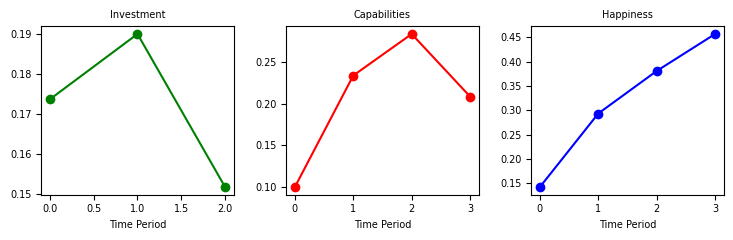

c_0 = 0.2


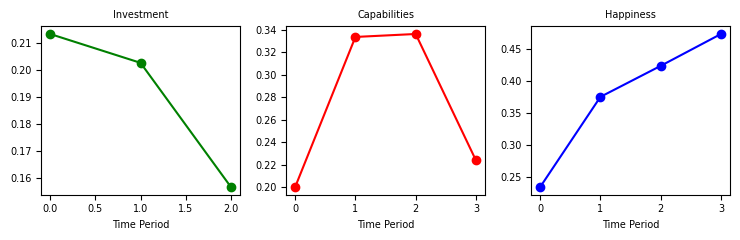

c_0 = 0.3


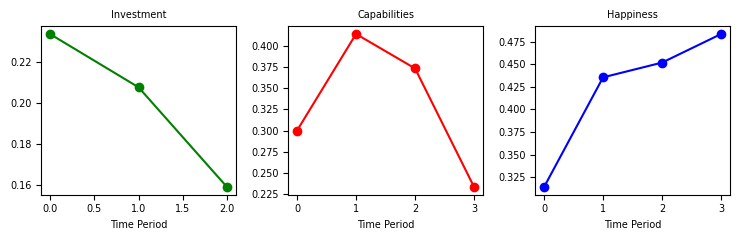

c_0 = 0.4


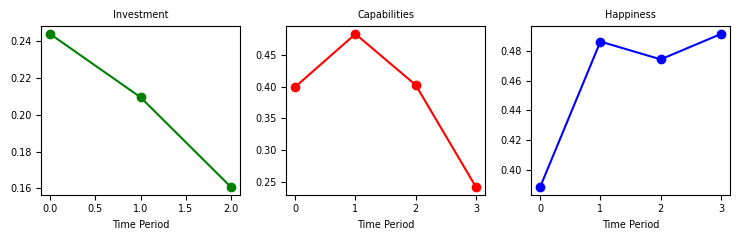

c_0 = 0.5


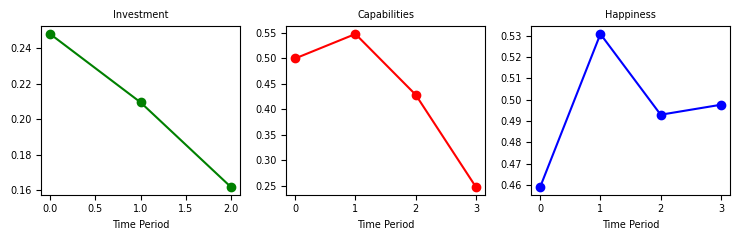

c_0 = 0.6


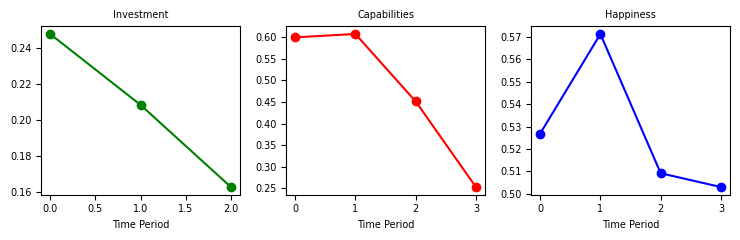

c_0 = 0.7


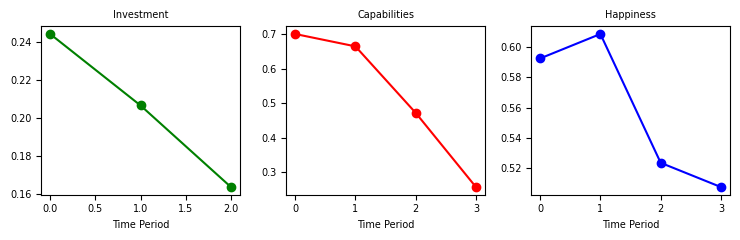

c_0 = 0.8


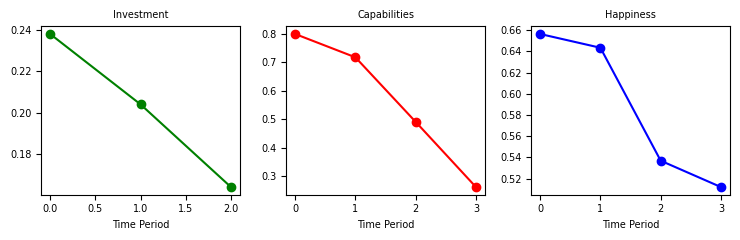

c_0 = 0.9


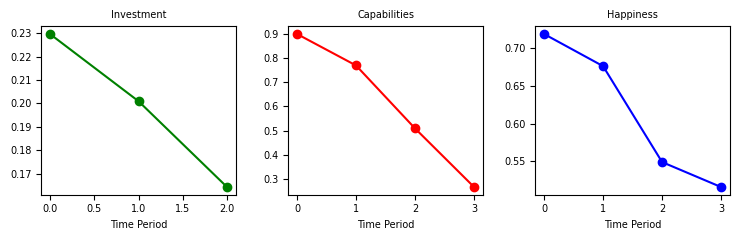

In [189]:
for x in range(1, 10):
    c_0 = x/10
    max_brute([(0,2), (0,2), (0,2)])


For low $c_0$ this is almost what we want: we're looking for investment and capabilities to have a hump-shape, because this should intuitively give the U-shape in happiness. However, the initial capabilities (and therefore initial happiness) are too low initially for the happiness profile to be suitably U-shaped. How can we fix this?

At high $c_0$, we notice that happiness is at its lowest in the last period. This intuitively can be seen as individuals observing the constraints and their objective function and deciding that the best way to approach their investment is to allow happiness to be low in later life due to how costly it is to preserve high happiness, while they enjoy the earlier parts of it more. This is the common theme: in many of the examples below, the solution exhibits this feature. The important question is whether it is possible to adjust the model setup so that this approach of accepting low happiness in later life is dominated by the investment schedule that gives us a U-shape, and if so, how.

----

Start with the comparative statics by seeing what the influence of changes in z are (to understand the role z plays)

In [190]:
z = 0.5

c_0 = 0.2


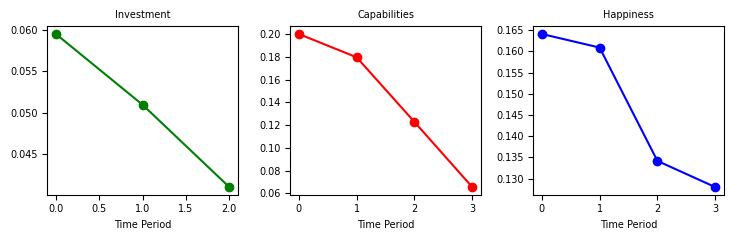

c_0 = 0.4


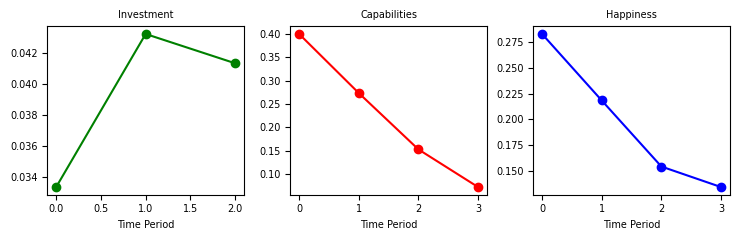

c_0 = 0.6


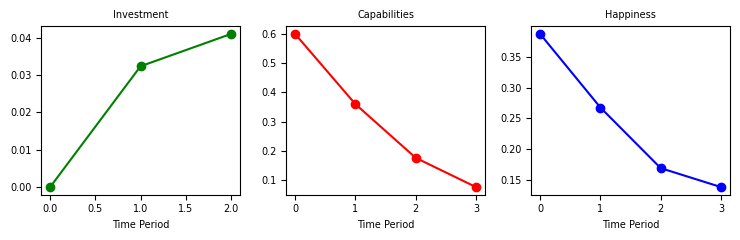

c_0 = 0.8


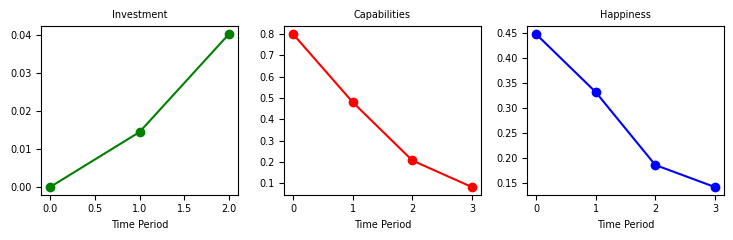

c_0 = 1.0


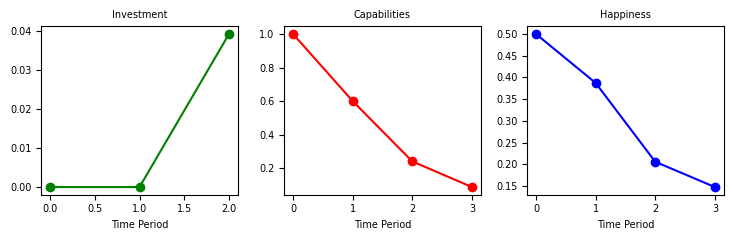

In [191]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,2), (0,2), (0,2)])

In general this lower z makes investment much less attractive as the rewards are less, but the cost is still the same. This leads us back to the default case of not really investing. This is what z does - it is a good way of regulating the tradeoff between costs and benefits of investing, without altering the most important parts of the model (the assumptions made about how ageing affects the equations)

Now try with higher z:

In [192]:
z = 2

c_0 = 0.2


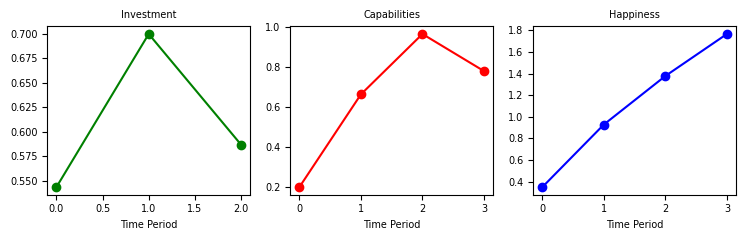

c_0 = 0.4


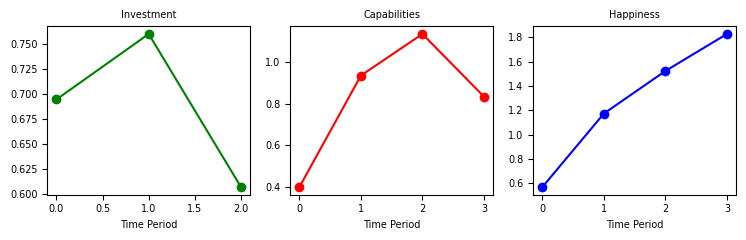

c_0 = 0.6


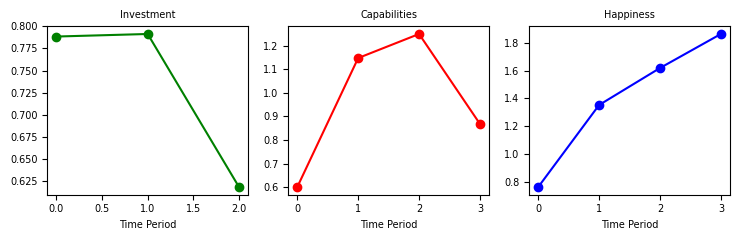

c_0 = 0.8


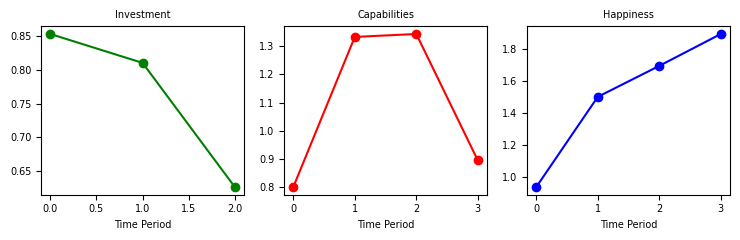

c_0 = 1.0


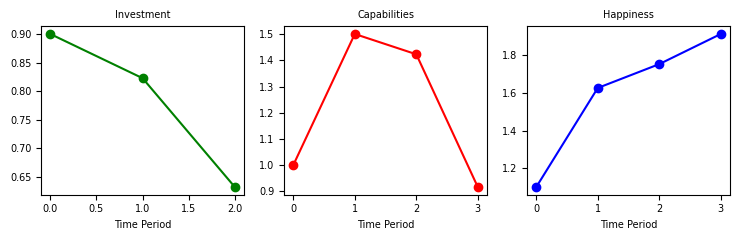

In [193]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,2), (0,2), (0,2)])

Higher $z$ incentivises more investment, as expected. Importantly, it seems to influence investment throughout the life span (i.e. investment is far higher across the values of $c_0$ in this case (and far lower in the lower $z$ case) than in the original case), while changes in $c_0$ appear to only really affect investment decisions early in the life span (i.e. investment at the end of the life span is largely constant for different values of $c_0$ for a given value of $z$). This seems logical and intuitive. We leave $z = 1$ until further notice.

In [194]:
# replace the previous change for the next section
z = 1

----

Now look at what happens if we change $k$ - i.e. the amount investment is scaled in calculating its cost to happiness. Start by adjusting the happiness equation appropriately, and then run the code for a higher value of $k$ than $k=1$

In [195]:
def happ(z, c, a, i=0):
    return z * (c ** a) - k*i

# this gives the relationship between capabilities and happiness: h_t = z * (c_t ** a) - k * i_t

In [196]:
k = 2

c_0 = 0.2


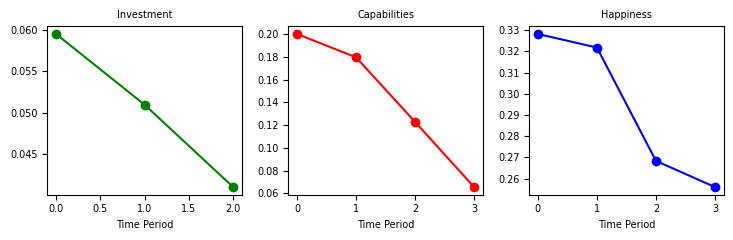

c_0 = 0.4


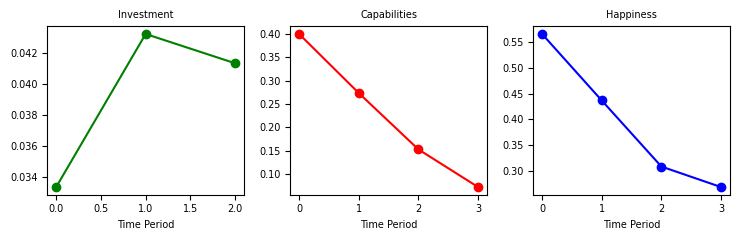

c_0 = 0.6


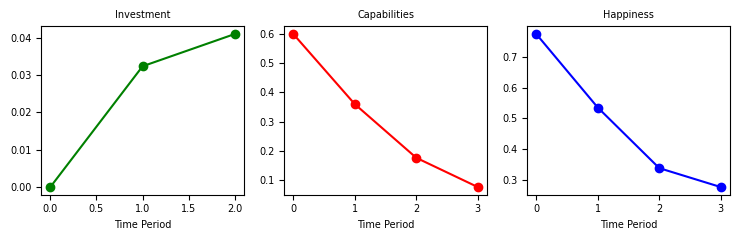

c_0 = 0.8


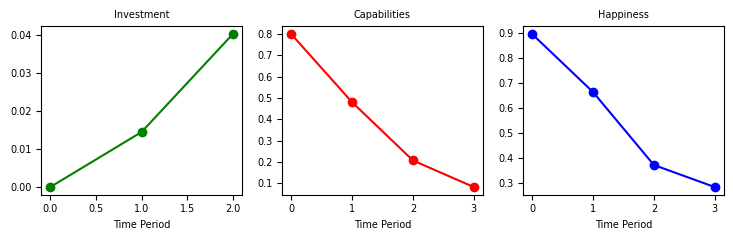

c_0 = 1.0


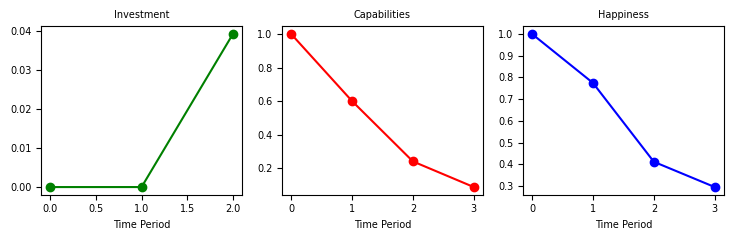

In [197]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,2), (0,2), (0,2)])

Now try for lower $k$:

In [198]:
k = 0.5

c_0 = 0.2


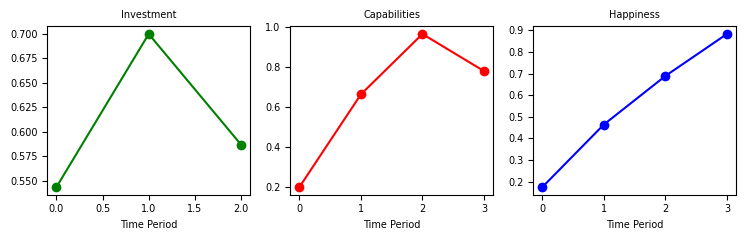

c_0 = 0.4


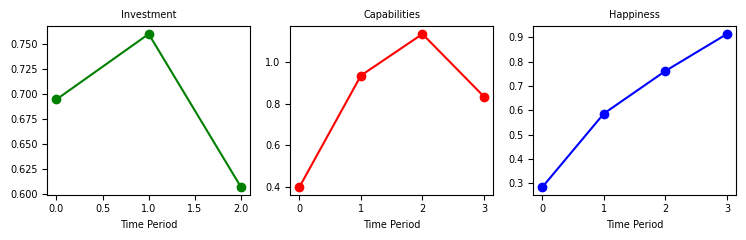

c_0 = 0.6


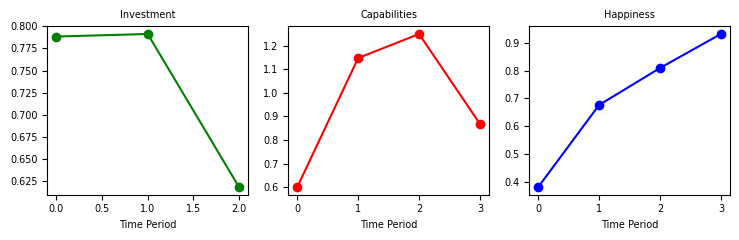

c_0 = 0.8


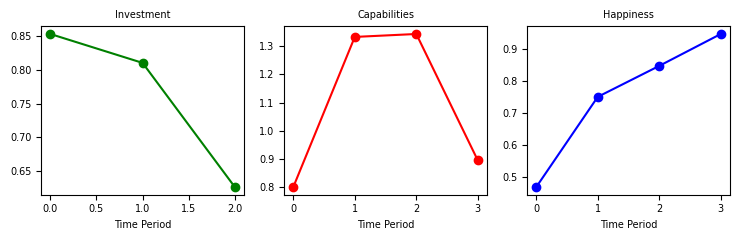

c_0 = 1.0


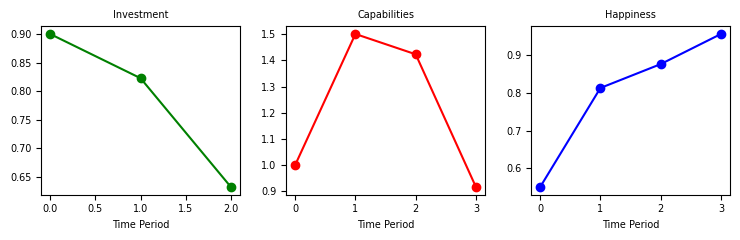

In [199]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,2), (0,2), (0,2)])

It appears to be the case that the effect of doubling $z$ and halving $k$ are equivalent - the investment and capabilities schedules are the same. Similarly, the effect of halving $z$ and doubling $k$ are equivalent. Also, in both cases, the pattern of happiness is the same but scaled. This is because the only adjustment to the model when changing $z$ or $k$ is how it affects the second equation (the happiness one), and doubling $z$ gives 2 * the happiness equation obtained by halving $k$. Since this is simply just a monotonic transformation, applied to happiness in all time periods, the incentives in terms of investment are the same in both cases.

Now reset everything to how it was before:

In [200]:
def happ(z, c, a, i=0):
    return z * (c ** a) - i

----

Now look at what happens if we change the objective function - instead of maximising $\Sigma^3_{i=0}$, now maximise min {$h_0, h_1, h_2, h_3$}, as suggested at the start.

In [201]:
def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, i_1)
    # h_2 = z * c_2 ** a - i_2
    h_2 = happ(z, c_2, a, i_2)
    # h_3 = z * c_3 ** a
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -min(h_0, h_1, h_2, h_3)

c_0 = 0.1


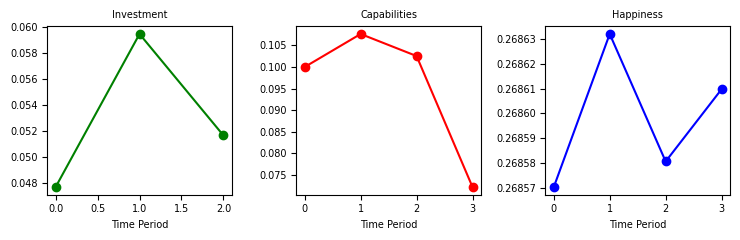

c_0 = 0.2


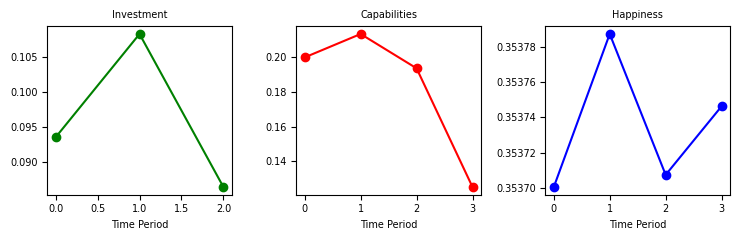

c_0 = 0.3


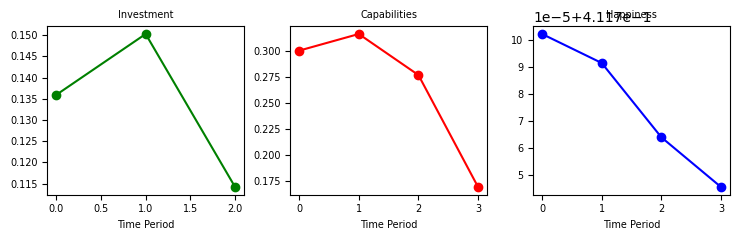

c_0 = 0.4


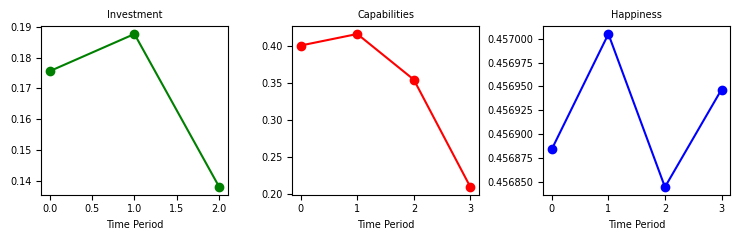

c_0 = 0.5


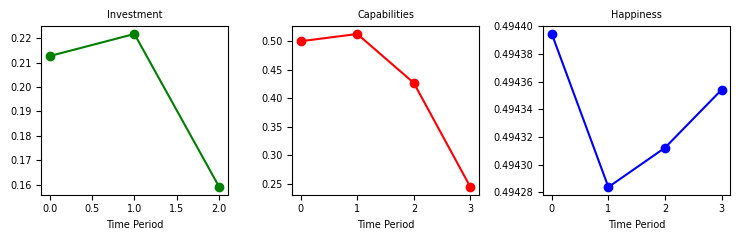

c_0 = 0.6


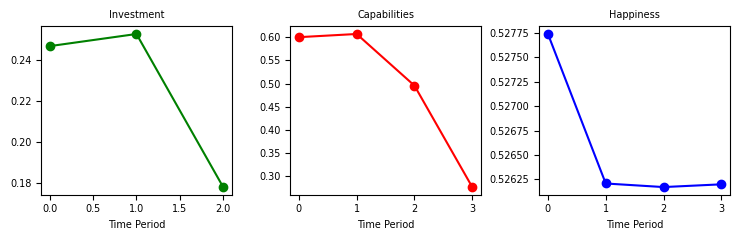

c_0 = 0.7


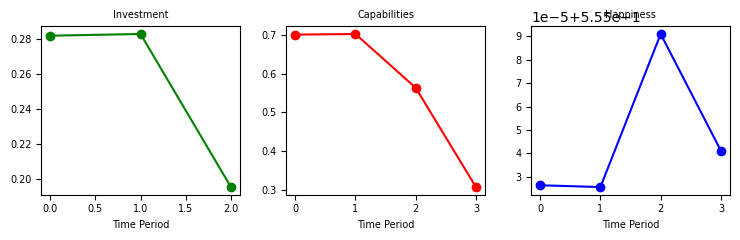

c_0 = 0.8


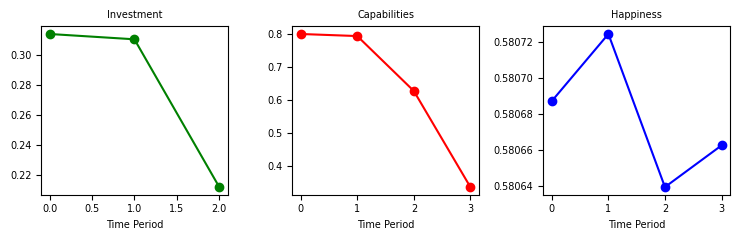

c_0 = 0.9


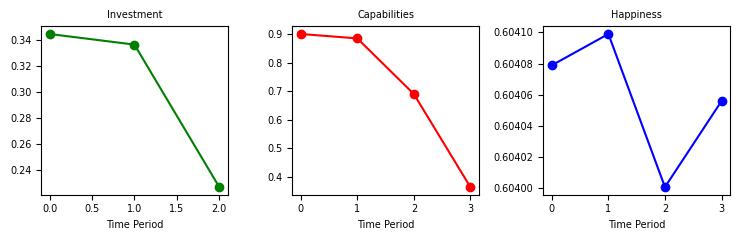

In [202]:
for x in range(1, 10):
    c_0 = x/10
    max_brute([(0,2), (0,2), (0,2)])

Because this is a far less 'nice' objective function, the numerical optimisation gives much more seemingly random results, so it is harder to draw conclusions from this. Maybe we should adjust the Ns argument in the brute command to make the grid more dense, and accept the computational demands. However, the main point to take away is that given this objective, the optimal investment schedule appears to be such that the happiness level is kept almost constant over the life span, particularly if $c_0$ is large. We will address this objective function again later.

In [203]:
# replace previous change

def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, i_1)
    # h_2 = z * c_2 ** a - i_2
    h_2 = happ(z, c_2, a, i_2)
    # h_3 = z * c_3 ** a
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -(h_0**0.5 + h_1**0.5 + h_2**0.5 + h_3**0.5)

----

Intuitively we want big investment in the middle, but incentivised by the pace at which capabilities drop off later. There must be a different objective function that ensures this for us

Suppose we increased the weighting of later life happiness, by again changing the objective function. This is almost assuming the conclusion, but might be instructive. We would intuitively expect that if happiness is worth more in later life, then people will invest more to ensure it is higher at that point, but that investment will be done in midlife to make it most efficient

In [204]:
# new objective function

def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, i_1)
    # h_2 = z * c_2 ** a - i_2
    h_2 = happ(z, c_2, a, i_2)
    # h_3 = z * c_3 ** a
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -(h_0**0.5 + h_1**0.5 + h_2**0.5 + 2*h_3**0.5)

c_0 = 0.2


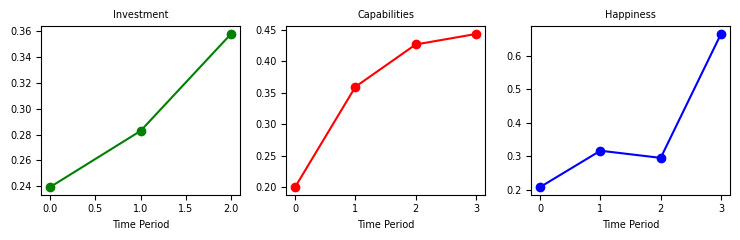

c_0 = 0.4


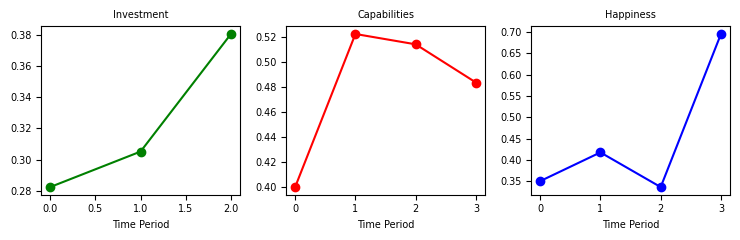

c_0 = 0.6


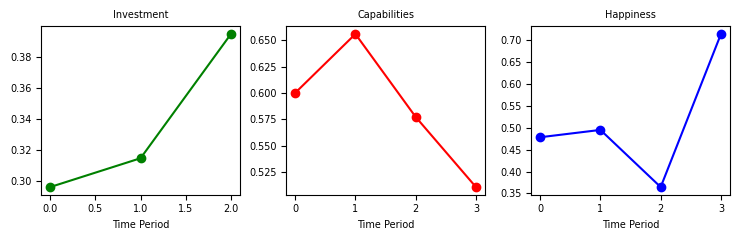

c_0 = 0.8


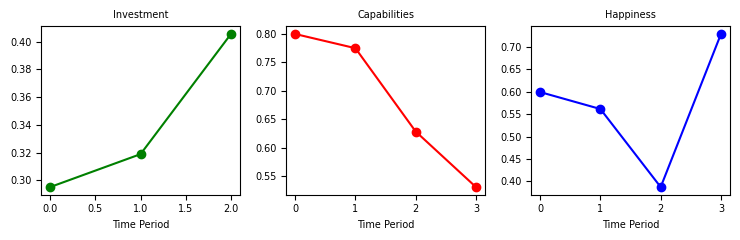

c_0 = 1.0


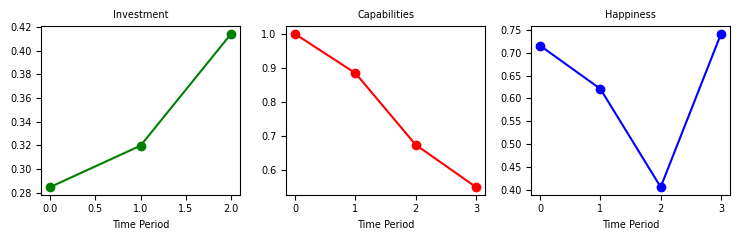

In [205]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,2), (0,2), (0,2)])

We do now get that consistent pattern that happiness increases at later life, regardless of $c_0$. However, the U still isn't symmetric, and for low $c_0$ there isn't even a U. In particular we notice that the investment schedule is reasonably constant: it just increases, with a faster increase towards the later point in life.

Keeping the same objective function, how do we motivate the large investment to start in a period slightly earlier than the penultimate one? Maybe make the depreciation lower? This is tried now:

In [206]:
d_0 = 0.2
d_1 = 0.5
d_2 = 0.8

c_0 = 0.2


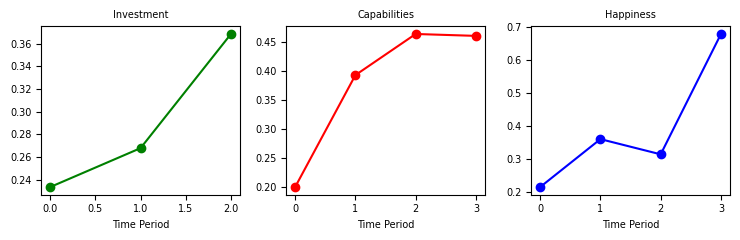

c_0 = 0.4


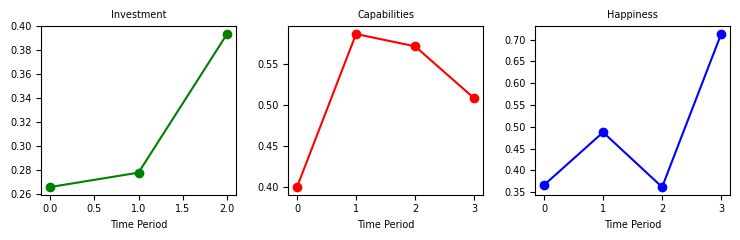

c_0 = 0.6


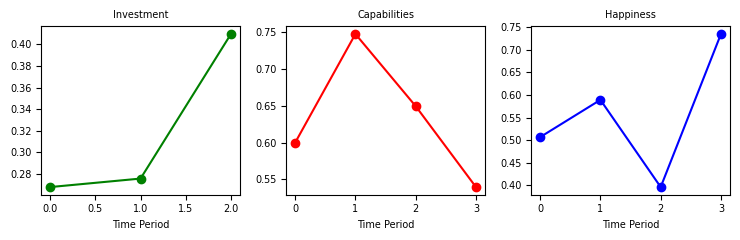

c_0 = 0.8


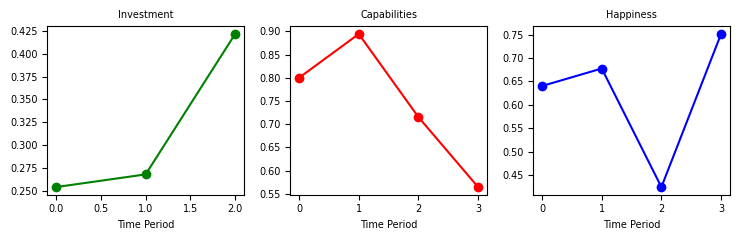

c_0 = 1.0


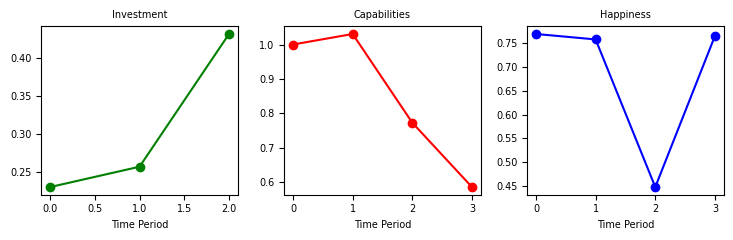

In [207]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,2), (0,2), (0,2)])

If anything, this has sort of had the opposite effect: in the second period there is even less of a drop. Now try again with higher depreciation than originally, to see what happens:

In [208]:
d_0 = 0.6
d_1 = 0.75
d_2 = 0.9

c_0 = 0.2


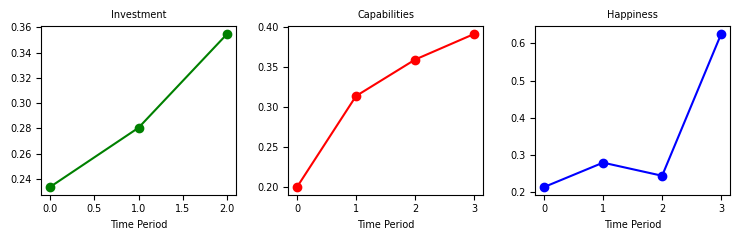

c_0 = 0.4


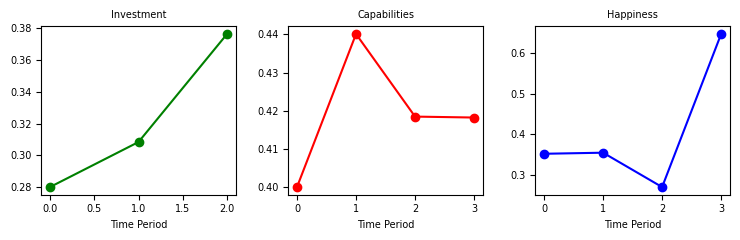

c_0 = 0.6


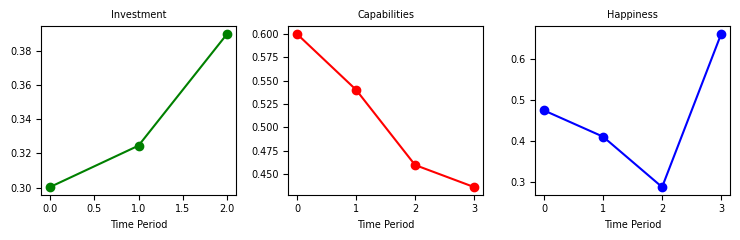

c_0 = 0.8


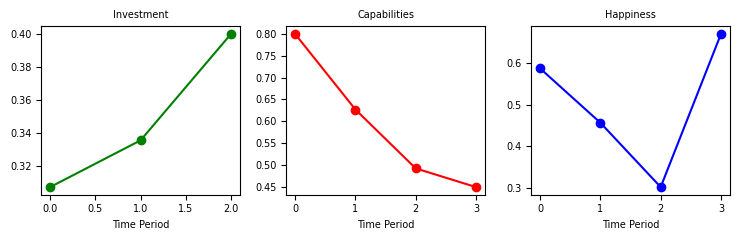

c_0 = 1.0


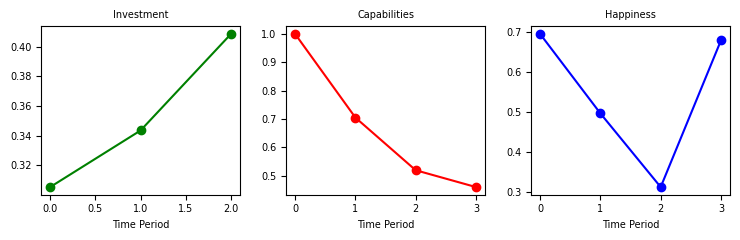

In [209]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,2), (0,2), (0,2)])

This is slightly better, but we still have the same asymmetric U, and the same increasing investment schedule and plateauing capabilities schedule. There doesn't seem to be much of a change in the basic patterns as the depreciation rate changes, and in particular they aren't really the patterns we want - the increase in happiness seems to be a mechanical result of the fact that in the last period individuals cannot invest (due to the structure of the model), and thus will naturally experience an increase in happiness ceteris paribus. This suggests that if this model was extended to many periods, we would possibly not get this U but instead a consistent decline until the final period, which is not what we want. However, it may also be a result of the fact that only the final period is weighted more strongly - if we were to weight more of the later periods more strongly, this may not be the case. This requires further investigation.

In [210]:
# replace changes

d_0 = 0.4
d_1 = 0.6
d_2 = 0.8

def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, i_1)
    # h_2 = z * c_2 ** a - i_2
    h_2 = happ(z, c_2, a, i_2)
    # h_3 = z * c_3 ** a
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -(h_0**0.5 + h_1**0.5 + h_2**0.5 + h_3**0.5)

----

We now incorporate more realistic elements of our problem into the model, and look at how they affect the solution. The first thing we do is change the law of motion equation, to incorporate diminishing returns to investment, which seems a reasonable assumption to make. In particular, we square root the investment term, so that it becomes $c_{t+1} = (1 - d_t) \cdot c_t + i_t^\frac{1}{2}$ - the net gain from investment (i.e. accounting for the second equation too) declines as the amount of investment increases.

In [211]:
def LoM(c, d, i):
    return (1 - d) * c + (i ** 0.5)

# this gives c_{t+1} = (1 - d_t) * c_t + i_t^(1/2)
# the power 1/2 on the investment reflects diminishing returns to investment

c_0 = 0.2


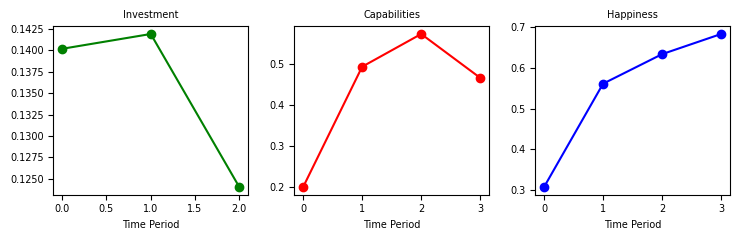

c_0 = 0.4


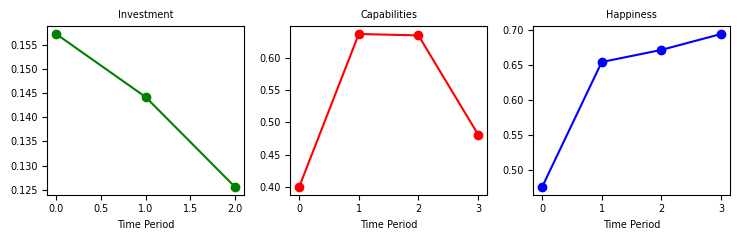

c_0 = 0.6


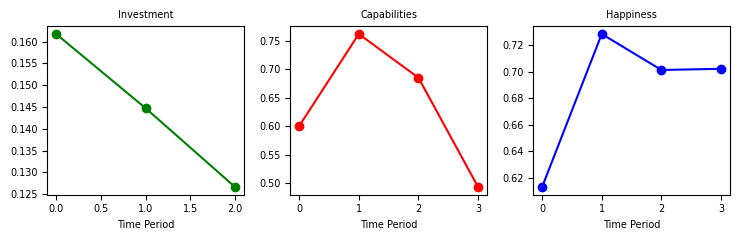

c_0 = 0.8


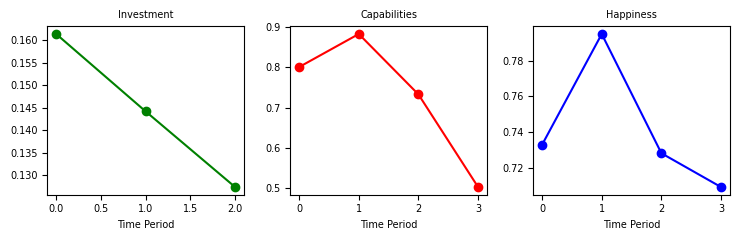

c_0 = 1.0


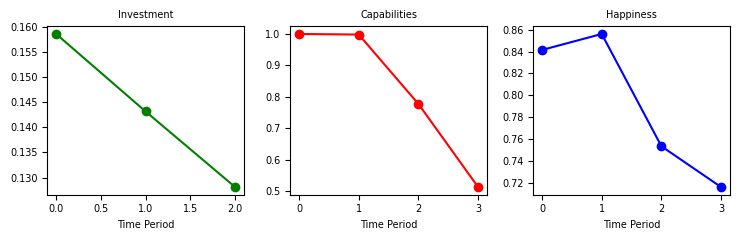

In [212]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,2), (0,2), (0,2)])

The result is pretty similar to the initial one - this doesn't appear to make too much of a difference. In particular, investment is always decreasing, which isn't what we want: we want it to increase, then plateau (or decrease in a model with more time periods)

----

How do we capture the effects of old age? The capability stock depreciates faster at this point, as the model already incorporates. We now also introduce the additional complication that the cost of investment rises at old age: we allow $k$ to increase over time



Intuitively the optimal solution in the face of these two age-varying factors could also be to not work against them to make old-age happiness higher, and instead allow old age to be a lower point of happiness, as we saw in the basic model. First investigate whether this is the case, then see what we can do - in particular, choosing the correct objective function seems very important to this point

In [213]:
def happ(z, c, a, k=1, i=0):
    return z * (c ** a) - k*i

# this gives h_t = z * (c_t ** a) - k_t * i_t
# the k reflects possible variance in the cost of investment

In [214]:
def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, 1, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, 1, i_1)
    # h_2 = z * c_2 ** a - 2 * i_2
    h_2 = happ(z, c_2, a, 2, i_2)
    # h_3 = z * c_3 ** a (- 1 * 0)
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -(h_0**0.5 + h_1**0.5 + h_2**0.5 + h_3**0.5)

In [215]:
def max_brute(ranges):
    # Perform the minimization
    result = brute(objective, ranges, Ns = 100)

    # The optimal values for i_0 and i_1
    i_0_opt, i_1_opt, i_2_opt = result

    h_0 = happ(z, c_0, a, 1, i_0_opt)
    c_1 = LoM(c_0, d_0, i_0_opt)
    h_1 = happ(z, c_1, a, 1, i_1_opt)
    c_2 = LoM(c_1, d_1, i_1_opt)
    h_2 = happ(z, c_2, a, 2, i_2_opt)
    c_3 = LoM(c_2, d_2, i_2_opt)
    h_3 = happ(z, c_3, a)

    h = [h_0, h_1, h_2, h_3]
    t_h = [0, 1, 2, 3]

    c = [c_0, c_1, c_2, c_3]
    t_c = [0, 1, 2, 3]

    i = result
    t_i = [0, 1, 2]

    print("c_0 =", c_0)

    plot(i, t_i, c, t_c, h, t_h)


c_0 = 0.1


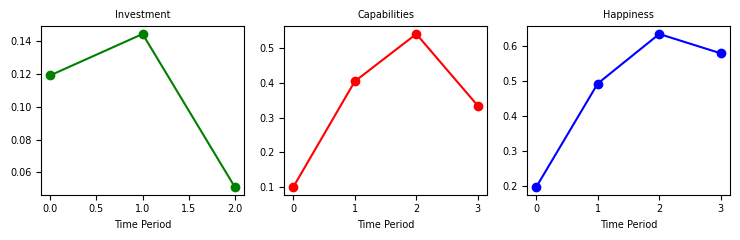

c_0 = 0.2


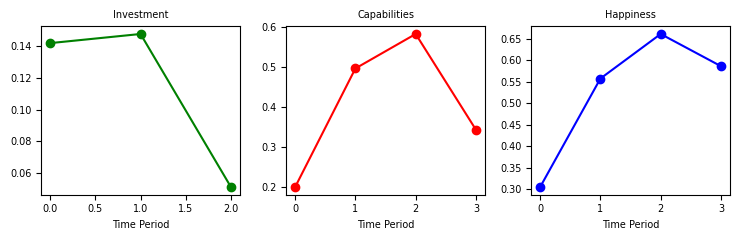

c_0 = 0.3


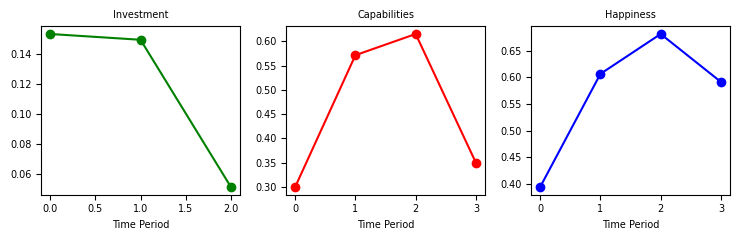

c_0 = 0.4


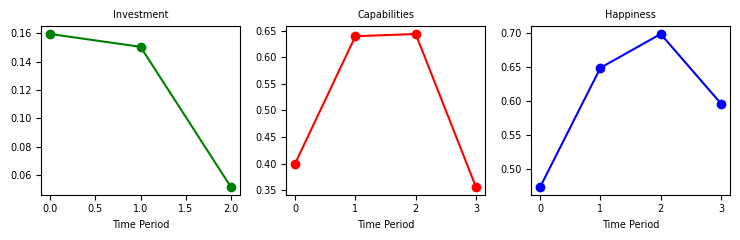

c_0 = 0.5


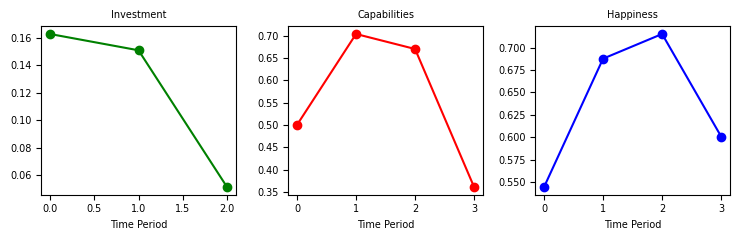

c_0 = 0.6


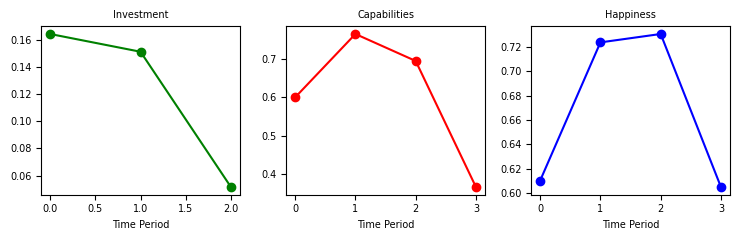

c_0 = 0.7


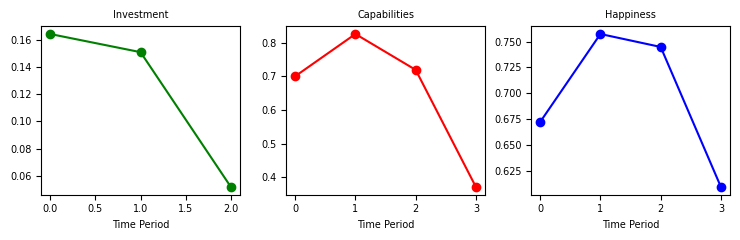

c_0 = 0.8


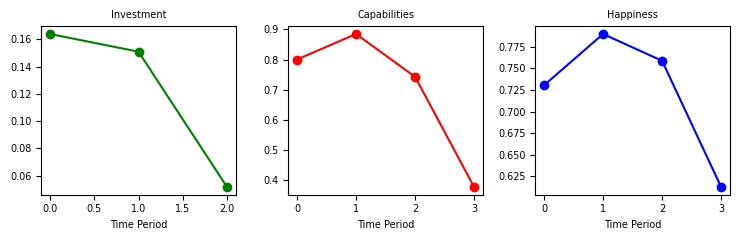

c_0 = 0.9


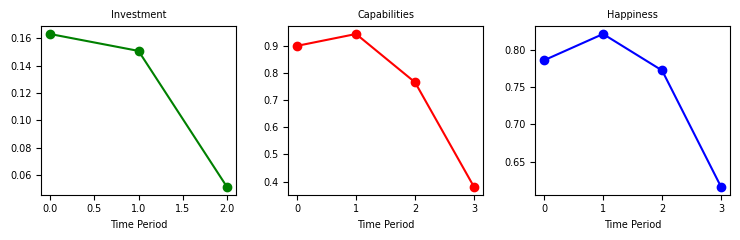

c_0 = 1.0


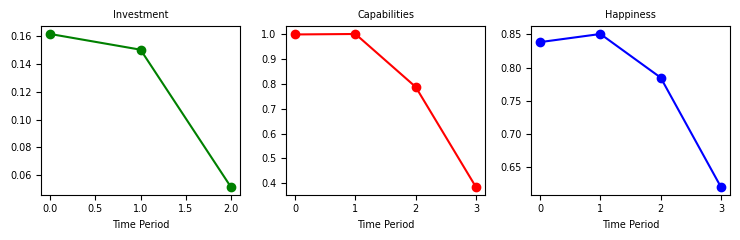

In [216]:
for x in range(1, 11):
    c_0 = x/10
    max_brute([(0,2), (0,2), (0,2)])

As we expected, across values of $c_0$, happiness declines towards the end of the lifespan. In particular, there is a consistent drop in investment in the last period, owing to the fact that investment is more expensive and thus less attractive.

----

What do we now do to address this fact? We have a more realistic model (which we are keeping) which is set up as follows:

max $\Sigma_{i=0}^3 h_i^\frac{1}{2}$ w.r.t  $i_0, i_1, i_2$  under the following constraints:
- $c_{t+1} = (1 - \delta_t) \cdot c_t + i_t ^ \frac{1}{2}$, for $t = 0, 1, 2$
- $h_t = z \cdot c_t ^ \alpha - k_t \cdot i_t$, for $t = 0, 1, 2, 3$
- $c_0$ given

In investigating this we have found that happiness initially rises and then falls, which is expected given the model setup. We now need to think about how to adapt this model such that happiness falls and then rises, and the place to start is the objective function.

Assuming the objective function is set by an evolutionary process, then it needs to be one that maximises the probability of survival/reproduction. 
- A good candidate would be the one we tried before: maximising the minimum. This is because if we assume there is a baseline level of happiness at which individuals are indifferent between being alive or dead, then evolution would want people to stay as far away from this point at all times

Now try this incorporated into our current model:

In [217]:
def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, 1, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, 1, i_1)
    # h_2 = z * c_2 ** a - 2 * i_2
    h_2 = happ(z, c_2, a, 2, i_2)
    # h_3 = z * c_3 ** a (- 1 * 0)
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -min(h_0, h_1, h_2, h_3)

To use this, we also need to increase the density of our grid used in the brute method - keep Ns at 100 (ideally should be a lot higher), but reduce the range in the argument to brute from $[0,2]^3$ to $[0,1]^3$, purely since investment seems to always be in $[0,1]$

c_0 = 0.2


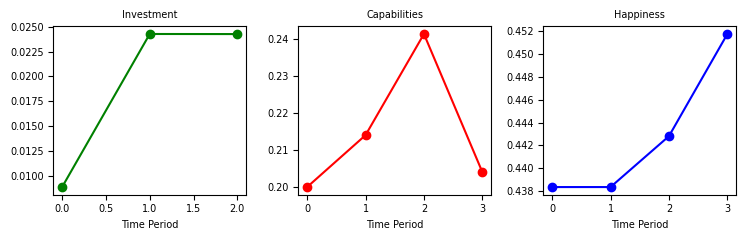

c_0 = 0.4


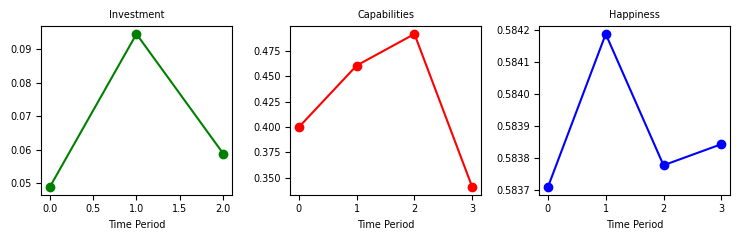

c_0 = 0.6


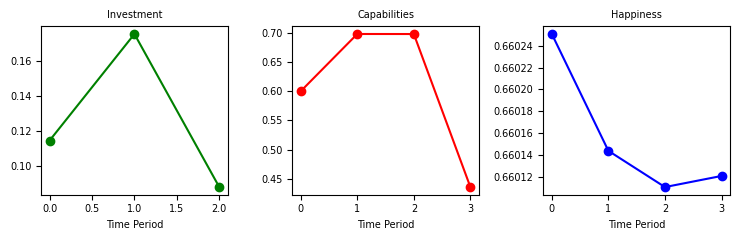

c_0 = 0.8


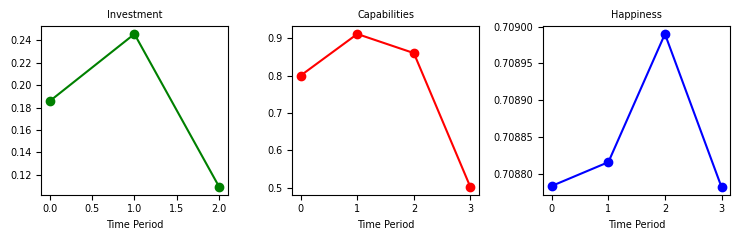

c_0 = 1.0


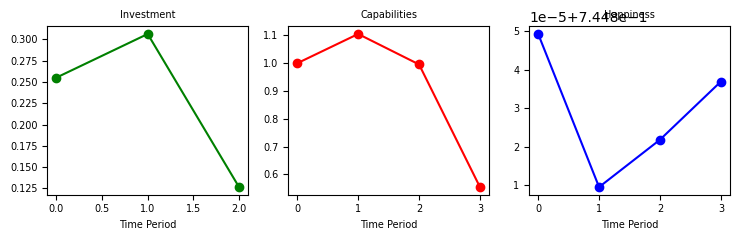

In [218]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,1), (0,1), (0,1)])

As before, for this objective function the optimal solution seems to be to set investment such that the happiness level is almost constant over the lifetime, which is also why we get such volatile patterns (as we are just using a grid). Humans are unlikely to be this precise - it therefore possible to include some sort of imprecision either in the problem setup or the objective function that accounts for this?

It should also be noticed that it is harder to smooth everything out perfectly when $c_0$ is lower: there are less initial capabilities that can be optimally drawn on to smooth the happiness over the future. However, investment is also lower in these periods, which seems intuitively weird. I need to give this more thought.

In [219]:
# restore the original model

def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, 1, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, 1, i_1)
    # h_2 = z * c_2 ** a - 2 * i_2
    h_2 = happ(z, c_2, a, 2, i_2)
    # h_3 = z * c_3 ** a (- 1 * 0)
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -(h_0**0.5 + h_1**0.5 + h_2**0.5 + h_3**0.5)

----

At this stage we have established in the model that old age is costly, both in terms of capability depreciation and investment cost. We then get the intuitive solution that happiness declines in later life. How can we adapt the objective function to prevent this, in a way that isn't just maximising the minimum, but fits with Nature's goals of maximising survival/reproduction

As noted at the start, we can see $\Sigma_{i=0}^3 h^\frac{1}{k}$ as approaching, in some sense, $min(h_i)$ as $k$ increases.

As such, we can treat this objective function as an imprecise version of the minimum, but for fairly large $k$.

Set $k = 10$, as a way of compromising between the original imprecise objective function and the exactly precise one investigated previously, and see what happens:

In [220]:
def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, 1, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, 1, i_1)
    # h_2 = z * c_2 ** a - 2 * i_2
    h_2 = happ(z, c_2, a, 2, i_2)
    # h_3 = z * c_3 ** a (- 1 * 0)
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    # return -min(h_0, h_1, h_2, h_3)
    return -(h_0**0.1 + h_1**0.1 + h_2**0.1 + h_3**0.1)

c_0 = 0.2


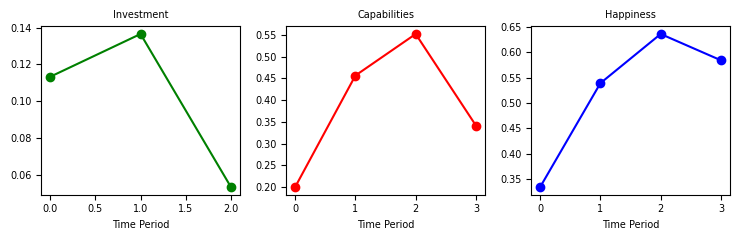

c_0 = 0.4


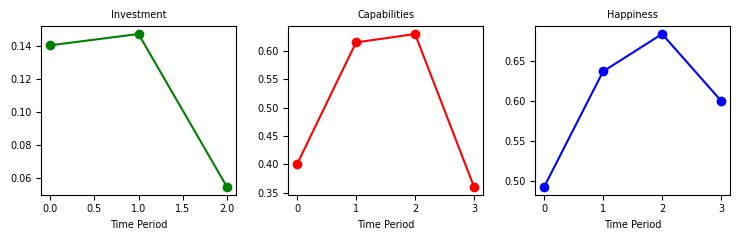

c_0 = 0.6


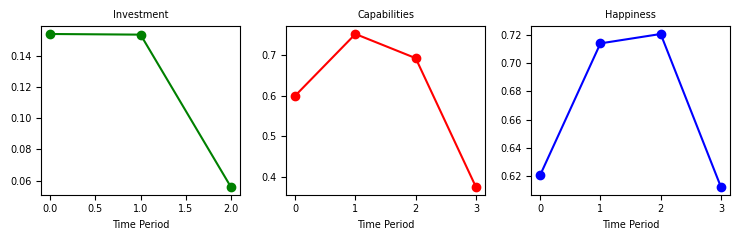

c_0 = 0.8


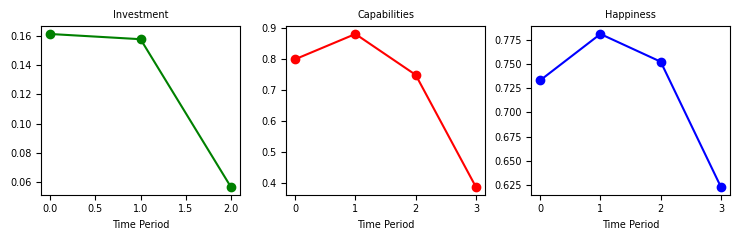

c_0 = 1.0


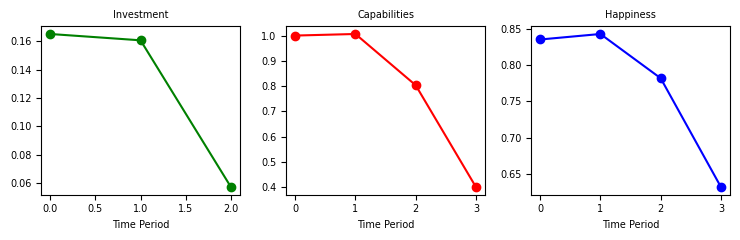

In [221]:
for x in range(1, 6):
    c_0 = x/5
    max_brute([(0,1), (0,1), (0,1)])

Unsurprisingly it is very similar to the $k=2$ case. We thus need to think of ways to adjust the model's equations to adapt the problem to get what we want.

In [222]:
# restore the original model

def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0
    h_0 = happ(z, c_0, a, 1, i_0)
    # h_1 = z * c_1 ** a - i_1
    h_1 = happ(z, c_1, a, 1, i_1)
    # h_2 = z * c_2 ** a - 2 * i_2
    h_2 = happ(z, c_2, a, 2, i_2)
    # h_3 = z * c_3 ** a (- 1 * 0)
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    return -(h_0**0.5 + h_1**0.5 + h_2**0.5 + h_3**0.5)

----

Now try a different way of incorporating the constraint that 'investment is more costly in old age': instead, frame it as 'investment is more costly when capabilities are lower', i.e. that the effectiveness of investment depends on the stock of capabilities owned at that point. This seems to fit better with what we see in reality: the reasons we presented for investment being costlier in old age were simply a result of the capability stock being particularly low at the time (e.g. worse health), and so we have been implicitly assuming that the capability stock is low in old age. This may be what gives us our conclusions.

To incorporate this constraint, remove the scaling of the investment cost $k$ on happiness, and instead multiply it by $\frac{1}{c_t}$:

max $\Sigma_{i=0}^3 h_i^\frac{1}{2}$ w.r.t  $i_0, i_1, i_2$  under the following constraints:
- $c_{t+1} = (1 - \delta_t) \cdot c_t + i_t^\frac{1}{2}$, for $t = 0, 1, 2$
- $h_t = z \cdot c_t ^ \alpha - \frac{1}{c_t} \cdot i_t$, for $t = 0, 1, 2, 3$
- $c_0$ given

There are many other ways to incorporate this constraint - investigate these

First redefine the relevant functions:

In [223]:
def happ(z, c, a, i=0):
    return z * (c ** a) - (i / c)

# this gives the relationship between capabilities and happiness: h_t = z * (c_t ** a) - i_t/c_t

In [224]:
# restore the original model

def objective(vars):
    i_0, i_1, i_2 = vars

    if i_0 < 0 or i_1 < 0 or i_2 < 0:
        return np.inf
    
    # Ensure the terms are non-negative before taking the power
    # c_1 = (1 - d_0) * c_0 + i_0
    c_1 = LoM(c_0, d_0, i_0)
    # c_2 = (1 - d_1) * c_1 + i_1
    c_2 = LoM(c_1, d_1, i_1)
    # c_3 = (1 - d_2) * c_2 + i_2
    c_3 = LoM(c_2, d_2, i_2)
    
    # If base of the power is negative, return a large penalty
    if c_1 < 0 or c_2 < 0 or c_3 < 0:
        return np.inf
    
    # h_0 = z * c_0 ** a - i_0/c_0
    h_0 = happ(z, c_0, a, i_0)
    # h_1 = z * c_1 ** a - i_1/c_1
    h_1 = happ(z, c_1, a, i_1)
    # h_2 = z * c_2 ** a - i_2/c_2
    h_2 = happ(z, c_2, a, i_2)
    # h_3 = z * c_3 ** a (- 0)
    h_3 = happ(z, c_3, a)

    # If happiness is negative, return a large penalty
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0:
        return np.inf
    
    # return -min(h_0, h_1, h_2, h_3)
    return -(h_0**0.5 + h_1**0.5 + h_2**0.5 + h_3**0.5)

In [225]:
def max_brute(ranges):
    # Perform the minimization
    result = brute(objective, ranges, Ns = 100)

    # The optimal values for i_0 and i_1
    i_0_opt, i_1_opt, i_2_opt = result

    h_0 = happ(z, c_0, a, i_0_opt)
    c_1 = LoM(c_0, d_0, i_0_opt)
    h_1 = happ(z, c_1, a, i_1_opt)
    c_2 = LoM(c_1, d_1, i_1_opt)
    h_2 = happ(z, c_2, a, i_2_opt)
    c_3 = LoM(c_2, d_2, i_2_opt)
    h_3 = happ(z, c_3, a)

    h = [h_0, h_1, h_2, h_3]
    t_h = [0, 1, 2, 3]

    c = [c_0, c_1, c_2, c_3]
    t_c = [0, 1, 2, 3]

    i = result
    t_i = [0, 1, 2]

    print("c_0 =", c_0)

    plot(i, t_i, c, t_c, h, t_h)

Now see what the solution gives:

c_0 = 0.1


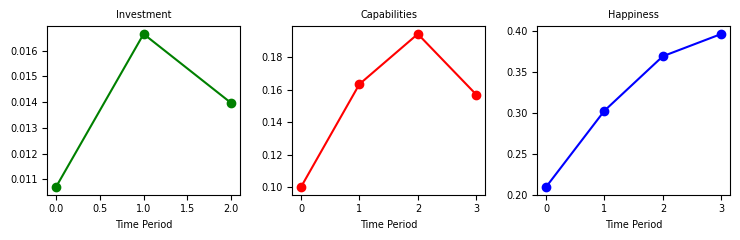

c_0 = 0.2


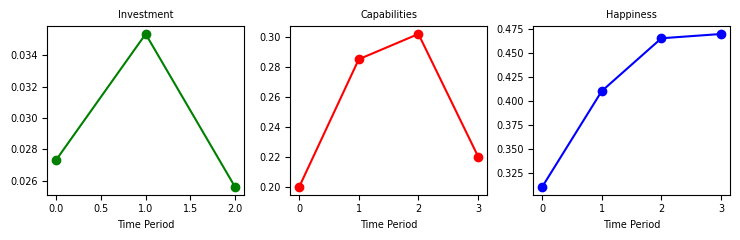

c_0 = 0.3


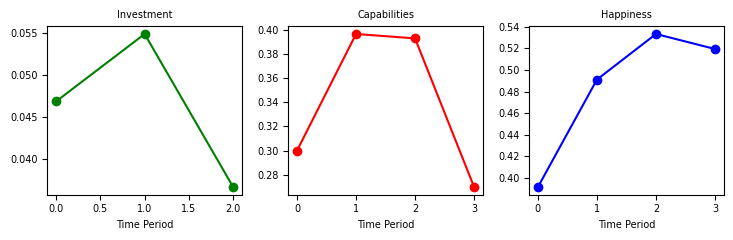

c_0 = 0.4


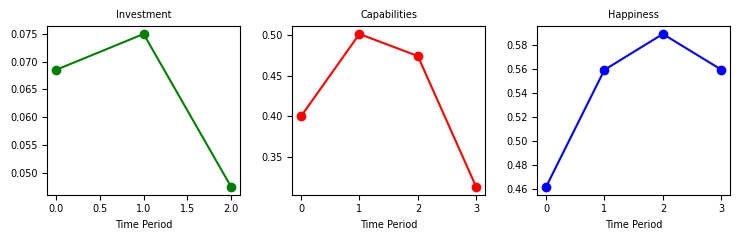

c_0 = 0.5


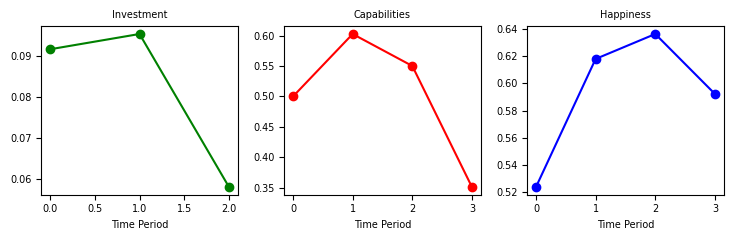

c_0 = 0.6


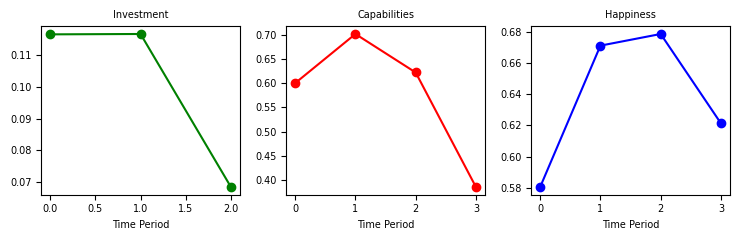

c_0 = 0.7


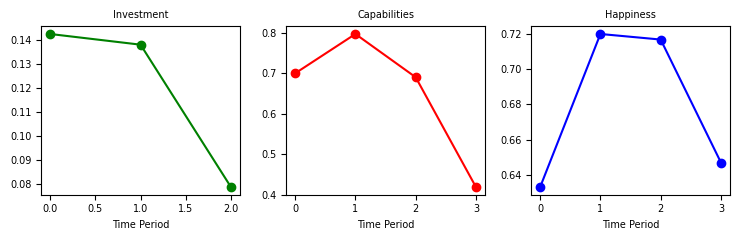

c_0 = 0.8


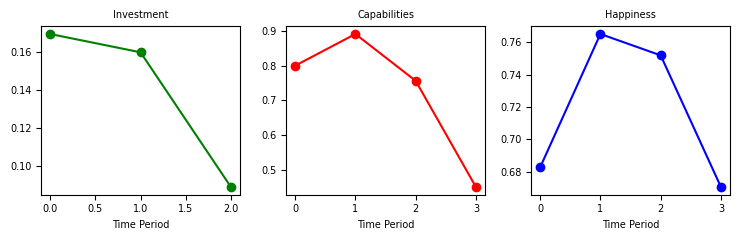

c_0 = 0.9


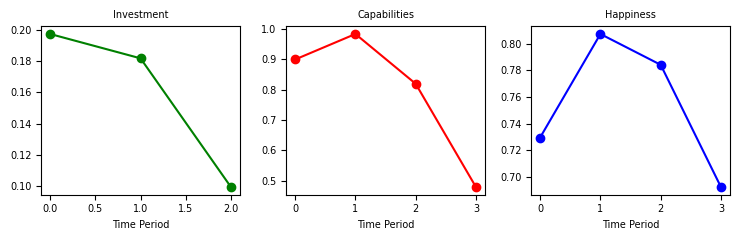

c_0 = 1.0


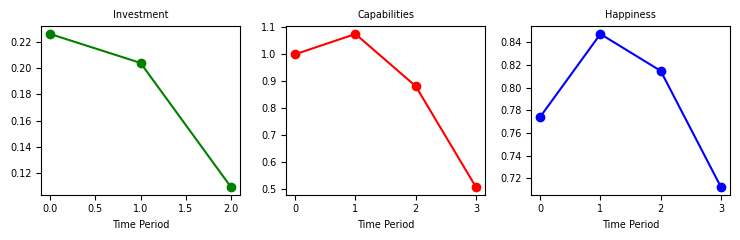

In [226]:
for x in range(1, 11):
    c_0 = x/10
    max_brute([(0,2), (0,2), (0,2)])

We see that for low $c_0$, there is no way of investing because any investment would lead happiness to be negative which isn't allowed, because $\frac{1}{c_t}$ is so large. However, when investment does become profitable, we get the same downward trend in investment, and hump-shape pattern in happiness, as before.

Now try another way of incorporating this adapted constraint - multiply the investment in the law of motion of capabilities by the capability stock itself:

max $\Sigma_{i=0}^3 h_i^\frac{1}{2}$ w.r.t  $i_0, i_1, i_2$  under the following constraints:
- $c_{t+1} = (1 - \delta_t) \cdot c_t + i_t^\frac{1}{2} \cdot c_t$, for $t = 0, 1, 2$
- $h_t = z \cdot c_t ^ \alpha - i_t$, for $t = 0, 1, 2, 3$
- $c_0$ given

Again, start by adjusting the relevant functions

In [227]:
def LoM(c, d, i):
    return (1 - d) * c + i**(1/2) * c

# this gives the law of motion of capabilities: c_{t+1} = (1 - d_t) * c_t + i_t

In [228]:
def happ(z, c, a, i=0):
    return z * (c ** a) - i

# this gives the relationship between capabilities and happiness: h_t = z * (c_t ** a) - i_t

Now run the optimisation:

c_0 = 0.1


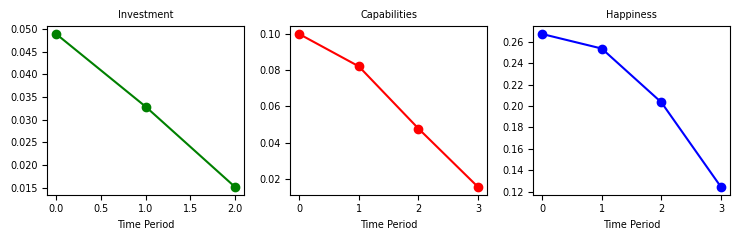

c_0 = 0.2


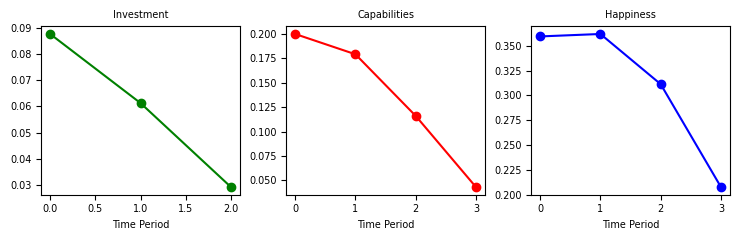

c_0 = 0.3


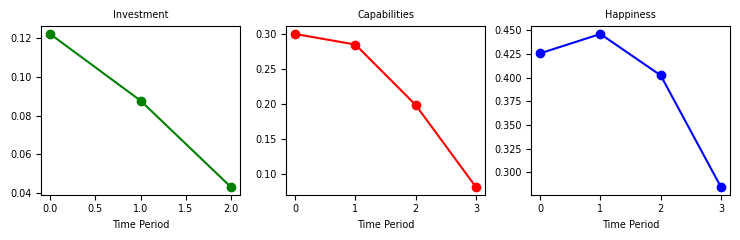

c_0 = 0.4


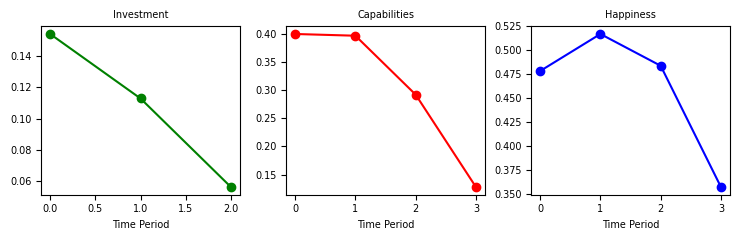

c_0 = 0.5


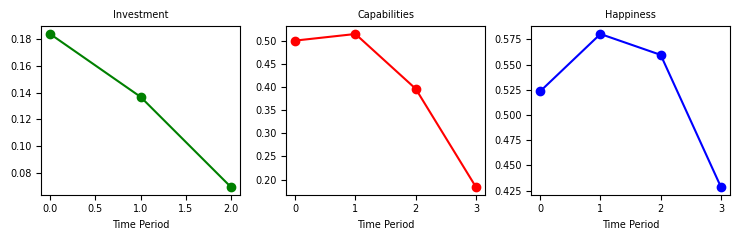

c_0 = 0.6


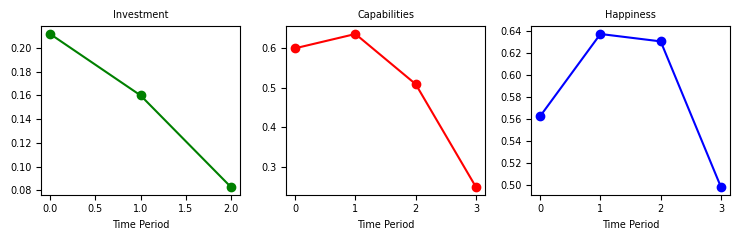

c_0 = 0.7


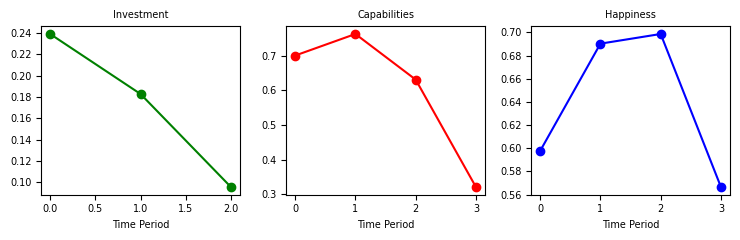

c_0 = 0.8


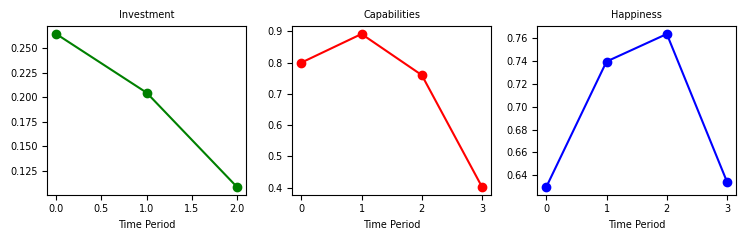

c_0 = 0.9


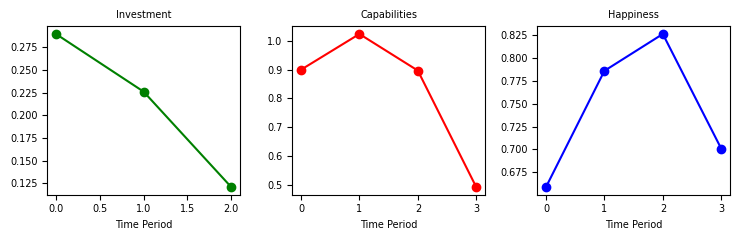

c_0 = 1.0


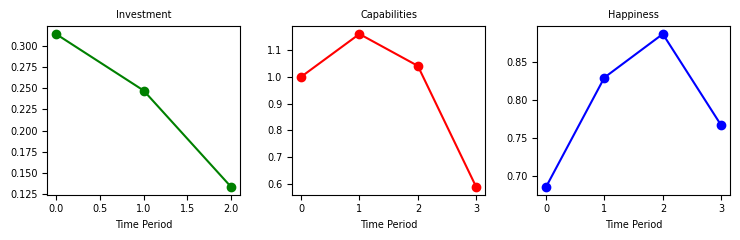

In [229]:
for x in range(1, 11):
    c_0 = x/10
    max_brute([(0,2), (0,2), (0,2)])

Again this has given the same patterns as before.

----

## The target solution

We now create a hypothetical investment schedule that aligns with our intuition as set out above, to see whether we do indeed get the happiness response we want:

c_0 = 1


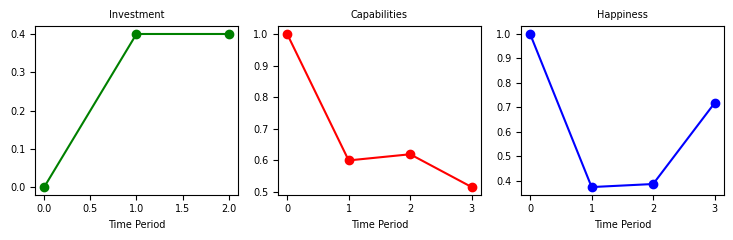

In [230]:
c_0 = 1

result = [0, 0.4, 0.4] # this is the hypothetical investment schedule: starts low, then increases, then plateaus

i_0_opt, i_1_opt, i_2_opt = result

h_0 = happ(z, c_0, a, i_0_opt)
c_1 = LoM(c_0, d_0, i_0_opt)
h_1 = happ(z, c_1, a, i_1_opt)
c_2 = LoM(c_1, d_1, i_1_opt)
h_2 = happ(z, c_2, a, i_2_opt)
c_3 = LoM(c_2, d_2, i_2_opt)
h_3 = happ(z, c_3, a)

h = [h_0, h_1, h_2, h_3]
t_h = [0, 1, 2, 3]

c = [c_0, c_1, c_2, c_3]
t_c = [0, 1, 2, 3]

i = result
t_i = [0, 1, 2]

print("c_0 =", c_0)

plot(i, t_i, c, t_c, h, t_h)

This gives roughly what we want (and is fairly robust), which tells us the intuitive mechanics of how investment feeds into happiness are largely correct. The question becomes how we get our model to generate such an investment schedule.

----

##### This is sort of where I am at the moment. I would like to come back to this and have a think again after not having looked at it for a while to see what seems intuitive then. I'd also like to look at the points in the below section and see what can be adjusted to produce the desired response.

----

## Notes and next steps

The things that need to be determined/investigated:
- how to deal with $c_0$? Is there some way of calibrating it based on other values? Or do we need to find a model that gives a U for all values of $c_0$?
    - same with $z$ and $k$ - we have set them to $1$, but how do we decide what they should be?
- make a larger model (i.e. more time periods)? 
    - it is possible a lot of the conclusions are being distorted by the fact that in the final period, there is no investment, while in a model with more time periods, this shouldn't matter as much
- Incorporate investment gains over multiple periods? 
    - e.g. investment in period 1 gives direct benefits in periods 2 and 3, rather than just 2
- What if the role of old people is to teach young people? I.e. they need to have some happiness in order to motivate them to help young people, which then increases survival probability? This would imply we can't look at the problem for an individual in isolation, and a completely different evolutionary model must be used. It may be impossible to fully understand the optimisation problem without incorporating other generations - this may require addressing the 'grandmother hypothesis'
    - this is an important point - these efforts may all be futile
- look in more detail at the min{$h_i$} objective function - particularly why the optimum is to arrange investment such that happiness is flat. Understand why this isn't necessarily the case for lower $c_0$, and then see if this can be applied to larger $c_0$ too, in a way that gives a consistent shape.


----

## Note - previous version

I had a previous version which gave a U-shape, but it turned out there were a lot of issues with it, and so it shouldn't be trusted. However, I've included the code below.

In particular, the optimisation method is 'minimize', using the Nelder-Read algorithm, which has the potential to get stuck at local minima (alongside various other issues). Instead of this we should really use the 'brute' method, which is used above within the 'max_brute' function, because there is only a small range on which the investment vector can lie, and it doesn't have many dimensions (3 in this case). In the below, the U-shape changes drastically if any of the initial parameters, the optimisation algorithm within 'minimise' or the initial guess change.

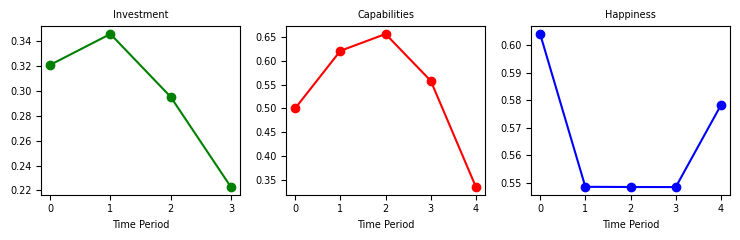

In [232]:
# Example values for the parameters z, c_0, a, d_0, d_1, d_2, d_3
z = 1
c_0 = 0.5
a = 0.5 # fits with literature (Graham and Oswald 2010)
d_0 = 0.4
d_1 = 0.5
d_2 = 0.6
d_3 = 0.8

# Define the function to be minimised
def objective_2(vars):
    i_0, i_1, i_2, i_3 = vars
    term1 = z * (c_0) ** a
    
    # Ensure the terms are non-negative before taking the power
    c_1 = (1 - d_0) * c_0 + i_0
    c_2 = (1 - d_1) * c_1 + i_1
    c_3 = (1 - d_2) * c_2 + i_2
    c_4 = (1 - d_3) * c_3 + i_3
    
    # If base of the power is negative, return a large penalty (i.e. a practically infeasible solution from a minimisation perspective)
    if c_1 < 0 or c_2 < 0 or c_3 < 0 or c_4 < 0:
        return np.inf
    
    h_0 = term1 - i_0**2
    h_1 = z * (c_1) ** a - 2*i_1**2
    h_2 = z * (c_2) ** a - 3*i_2**2
    h_3 = z * (c_3) ** a - 4*i_3**2
    h_4 = z * (c_4) ** a

    # Also ensure happiness is non-negative in every period: if happiness is too small, return a large penalty     
    if h_0 < 0 or h_1 < 0 or h_2 < 0 or h_3 < 0 or h_4 < 0:
        return np.inf
    
    return -(min(h_0, h_1, h_2, h_3, h_4)) # i.e. maximise the minimum value of happiness


# Perform the minimization, with an initial guess and bounds on the variables
result = minimize(objective_2, [0,0,0,0], bounds=[(0, None), (0, None), (0, None), (0, None)], method = 'Nelder-Mead')

# The optimal values for i_0 and i_1
i_0_opt, i_1_opt, i_2_opt, i_3_opt = result.x

i = [i_0_opt, i_1_opt, i_2_opt, i_3_opt]
t_i = [0, 1, 2, 3]

# Happiness evolution
# MAKE SURE THESE MATCH UP WITH THE EQUATIONS IN THE FUNCTION

h_0 = z * (c_0) ** a - i_0_opt**2
c_1 = (1 - d_0) * c_0 + i_0_opt
h_1 = z * (c_1) ** a - 2 * i_1_opt**2
c_2 = (1 - d_1) * c_1 + i_1_opt
h_2 = z * (c_2) ** a - 3 * i_2_opt**2
c_3 = (1 - d_2) * c_2 + i_2_opt
h_3 = z * (c_3) ** a - 4 * i_3_opt**2
c_4 = (1 - d_3) * c_3 + i_3_opt
h_4 = z * (c_4) ** a
 

h = [h_0, h_1, h_2, h_3, h_4]
t_h = [0, 1, 2, 3, 4]

c = [c_0, c_1, c_2, c_3, c_4]
t_c = [0, 1, 2, 3, 4]

plot(i, t_i, c, t_c, h, t_h)